In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.100563 -0.289893 -0.151300  0.523311 -0.299351 -0.408019  0.162838   
  1  -1.104589 -0.967140 -0.434450 -1.036870 -0.252820 -0.394942 -0.233437   
  2  -0.390661 -0.408658  0.229103 -0.183784  0.746187 -0.792561  0.633598   
  3  -0.817885  0.660250  0.434692 -0.681871  0.447503  0.712246  0.968510   
  4   0.588534  0.107561  0.224694 -0.267966  0.731964  1.041098  0.322002   
  5  -0.928394 -0.251497  0.658134  0.509653  0.893751  0.491095  1.538499   
  6  -1.162681 -0.808378  0.264939  0.793614 -0.637800  0.766615 -0.080626   
  7  -0.815348 -0.079081  0.535242 -0.860999 -0.289970 -1.145349 -0.643245   
  8  -0.103352 -0.411422  0.093747 -0.498526  0.546378 -0.237584 -0.049660   
  9  -0.396736  0.774139 -0.000678  0.260788  0.066922  0.648213 -0.223439   
  10 -0.181008 -0.423168  0.349295 -0.120402  0.014611  0.416733  0.304323   
  11 -0.210202 -0.686923 -0.911023 -0.538846  0.490182  0.224014 -0.626437   
  12 -1.024149 -0.332117 -0.823446 -0.791112 -1.428484 -0.527142  0.534038   
  13 -0.458374  0.352941  0.484846  0.501744  1.297784 -1.405130 -0.287368   
  14 -0.962047 -0.597195  0.020374  1.352912  0.051257 -0.248078  0.877175   
  15  0.306478  0.008877  0.989682 -1.276205 -0.370118  0.425515  0.099527   
  16 -0.557818 -0.004601 -0.032566 -0.462883 -1.147089  1.171470  0.042535   
  17 -0.341737  0.738898 -0.394835 -0.924054 -0.272140  0.103576  0.093153   
  18  0.195346 -1.349698 -0.414007  0.080948  0.756597  0.418123  0.527900   
  19  0.464400 -0.047572  0.660576 -0.669163 -0.326537  0.510085  0.068675   
  20 -0.722937  0.047345  0.027303  0.196376 -0.230747 -0.524863  0.231643   
  21  0.477717  0.915962  0.347130 -0.254580 -1.147297 -0.872148 -1.025883   
  22 -0.595939 -0.569037 -0.407288 -0.613146  0.320622  0.361814  0.729940   
  23 -0.795160  0.055350  1.223329 -0.175891  0.418860  0.534988  0.589190   
  24 -1.205569 -1.338185 -0.493979  0.114877 -1.074801  0.025093 -0.545281   
1 0   0.562570 -0.235706  0.042898 -0.489315 -0.057701 -0.501879  0.506658   
  1   0.181578 -1.112010 -0.182025 -0.366883  0.391389 -0.268582 -0.822486   
  2   0.282546  0.815008  0.568556 -0.136744 -0.612582 -0.258916  0.242304   
  3  -0.416816 -0.025438 -0.622156 -1.319998 -1.205792  0.091745  0.862077   
  4  -0.516709 -0.734585 -0.388204 -0.915890  0.210620  0.235307 -0.702009   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.475361  0.529974 -0.148206  ...  0.155306  0.578324 -0.254431   
  1   0.594189 -0.122207  0.511839  ...  0.393255  0.939144  0.099418   
  2   0.523529  0.074215  1.093307  ... -0.568941  0.563480 -0.068249   
  3   0.574888 -0.306419  0.262693  ... -0.564978  0.680788  1.115164   
  4   0.266874 -0.140318  0.534360  ...  0.387587  1.401477 -0.324939   
  5   0.585334  0.433483  0.641143  ... -0.492932 -0.065594 -0.979394   
  6   0.225589  0.296449  0.593414  ... -0.380502 -0.044418 -0.329360   
  7  -1.189005  0.023255  1.170672  ...  0.734749  0.424502 -0.374228   
  8  -0.295318 -0.255125  1.010556  ... -0.385818 -0.234223 -0.984799   
  9   0.557402 -0.239737 -0.878739  ... -0.079525 -0.336483 -0.654478   
  10  0.818252  0.130638 -0.369547  ... -1.129250  0.891011  0.516531   
  11  0.043288 -0.827797  1.028139  ...  0.341100  0.994769  0.436509   
  12  0.326361  0.459719  0.191537  ...  0.225186  0.328255  0.979635   
  13  0.420729 -0.182790 -0.033221  ... -0.704474 -0.524268 -0.107851   
  14  1.008486 -0.952744  0.139575  ... -0.233236  0.901091  0.740735   
  15  1.011101  1.277223  0.517354  ... -1.053146  0.016820  0.928160   
  16  0.531373  0.261622  0.295759  ... -0.352186  0.164451  0.154052   
  17  0.920321  1.808588  1.349917  ... -0.461578  0.128643  0.646449   
  18  0.596885 -1.107329  0.225546  ...  0.336030  0.107258  0.167866   
  19  1.203605  0.465339 -0.006248  ... -0.738330 -0.356335 -0.047843   
  20  1.419012  0.156873 -0.576877  ... -1.260467  0.076566 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.031881  0.032611  31.642275  9.685652e-220  0.967965  1.095797


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



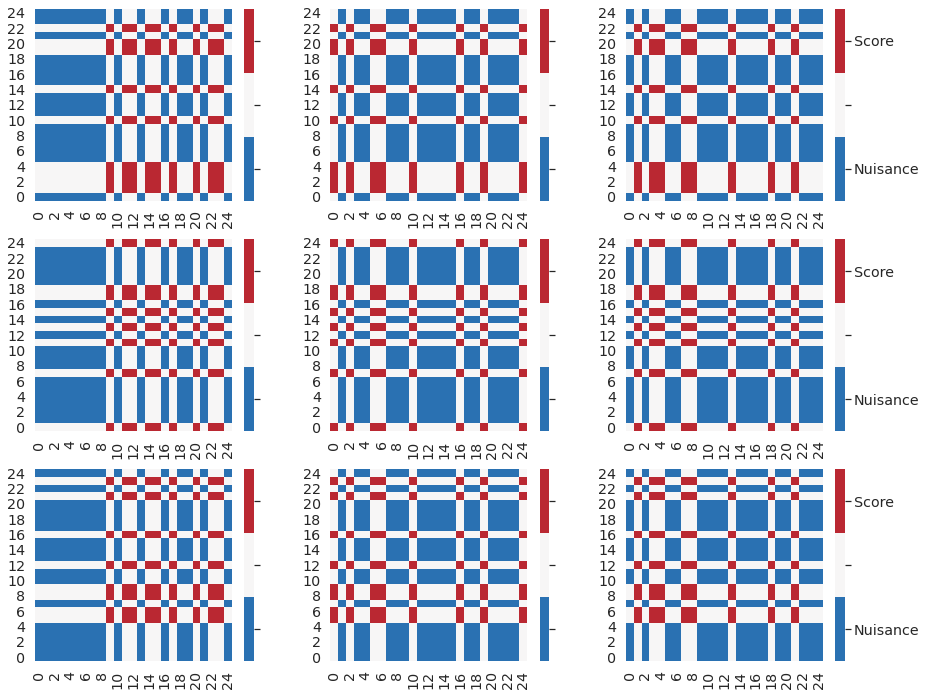

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



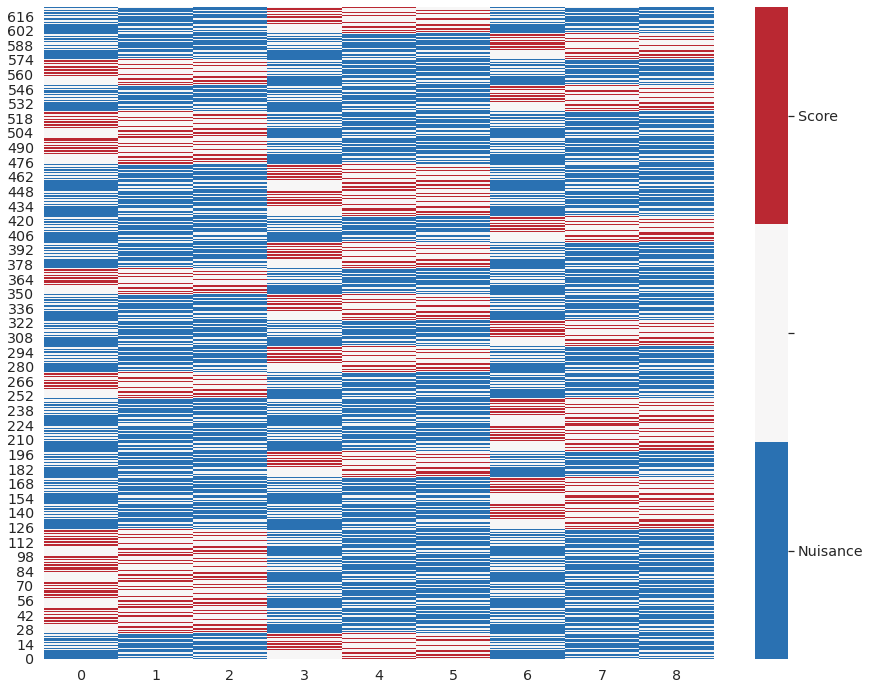

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])